In [467]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import h5netcdf
import cartopy.crs as ccrs

import cartopy.feature as cfeature
import matplotlib.colors as mcolors

get novel dataset but w/ temp data included
==

In [468]:
file_path_landfrac = r"D:\MPI LR Data\sftlf_fx_MPI-ESM1-2-LR_ssp245_r11i1p1f1_gn.nc"
landfrac_dataset = xr.open_dataset(file_path_landfrac)
file_path_temp = r"D:\MPI LR Data\tas_Amon_MPI-ESM1-2-LR_G6sulfur_r1i1p1f1_gn_207501-209912_combined.nc"
temperature_dataset = xr.open_dataset(file_path_temp)
file_path_pr = r"D:\MPI LR Data\pr_MPI-ESM1-2-LR_G6sulfur_dataset_2070-2099.nc"
pr_dataset = xr.open_dataset(file_path_pr)
file_path_area = r"D:\MPI LR Data\areacella_fx_MPI-ESM1-2-LR_ssp245_r11i1p1f1_gn.nc"
area_dataset = xr.open_dataset(file_path_area)

making A and B zones so the temperature data is still intact
==

In [469]:
mask_on_pr_grid = (
    landfrac_dataset["sftlf"]
      .interp(lat=pr_dataset.lat, lon=pr_dataset.lon)
      > 35
)
pr_dataset_masked = pr_dataset.where(mask_on_pr_grid)

mask_on_tas_grid = (
    landfrac_dataset["sftlf"]
      .interp(lat=temperature_dataset.lat, lon=temperature_dataset.lon)
      > 35
)
temperature_dataset_masked = temperature_dataset.where(mask_on_tas_grid)

In [470]:
#temperature_dataset_masked = temperature_dataset.where(landfrac_dataset['sftlf'] > 50)
#pr_dataset_masked = pr_dataset.where(landfrac_dataset['sftlf'] > 50)

start = '2085-01-01'
end = '2099-12-31' #30 for UKESM, all months have 30 days in this model

tas = temperature_dataset_masked['tas'].sel(time=slice(start, end))

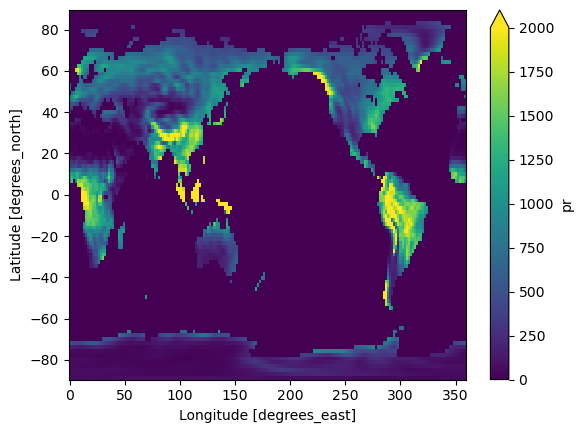

In [471]:
pr = pr_dataset_masked['pr'].sel(time=slice(start, end))
pr_2 = (pr*60*60*24*30)
lat = pr['lat']
pr_converted = (pr*60*60*24*365.25)

pr_monthly = pr_2.groupby('time.month').mean()
P_ann = pr_monthly.sum(dim='month')
P_ann.plot(vmin=0, vmax=2000)

In [472]:
MAT = tas.mean(dim='time')
MAP = (pr*60*60*24*365.25).mean(dim='time') 

winter_mask_NH = np.logical_or(pr.time.dt.month >= 10, pr.time.dt.month <= 3)  #Oct–Mar
winter_mask_SH = np.logical_and(pr.time.dt.month >= 4, pr.time.dt.month <= 9)  #Apr–Sep
#defining hemispheres by their position relative to the equator
is_NH = pr.lat >= 0
is_SH = pr.lat < 0

In [473]:
#use these variables to count months, they have a time dim = 120
#creating masks for each hemisphere - precip
pr_winter = xr.where(is_NH, pr.where(winter_mask_NH, pr), pr.where(winter_mask_SH, pr))
pr_summer = xr.where(is_NH, pr.where(~winter_mask_NH, pr), pr.where(~winter_mask_SH, pr))
#creating masks for each hemispheere - temp
tas_winter = xr.where(is_NH, tas.where(winter_mask_NH, tas), tas.where(winter_mask_SH, tas))
tas_summer = xr.where(is_NH, tas.where(~winter_mask_NH, tas), tas.where(~winter_mask_SH, tas))

In [474]:
#winter month masks
months = pr['time'].dt.month
winter_mask_NH = (months >= 10) | (months <= 3)
winter_mask_SH = (months >= 4) & (months <= 9)

#broadcast hemisphere masks over time
is_NH_masked = is_NH.broadcast_like(pr)
is_SH_masked = is_SH.broadcast_like(pr)


#Create full winter_mask (time, lat, lon)
winter_mask_full = xr.where(
    is_NH_masked, 
    winter_mask_NH, 
    winter_mask_SH
)

#Apply winter mask to precipitation
pr_winter = pr.where(winter_mask_full)

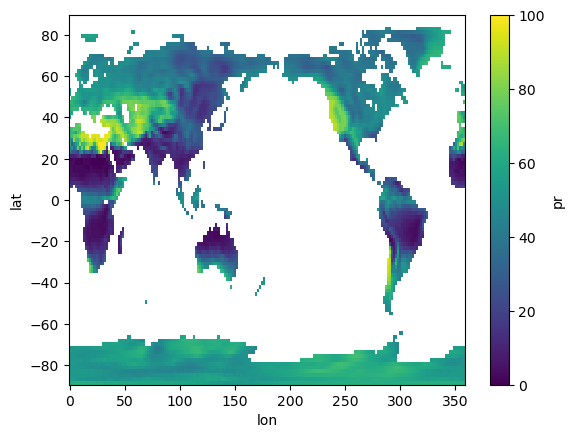

In [475]:
# Sum over time (no unit conversion needed for %)
pr_winter_total = pr_winter.sum(dim='time')
pr_total = pr.sum(dim='time')

# Compute percent of annual precip that occurs in winter
Pw = ((pr_winter_total / pr_total) * 100)
Pw.plot(vmin=0, vmax=100, cmap='viridis')

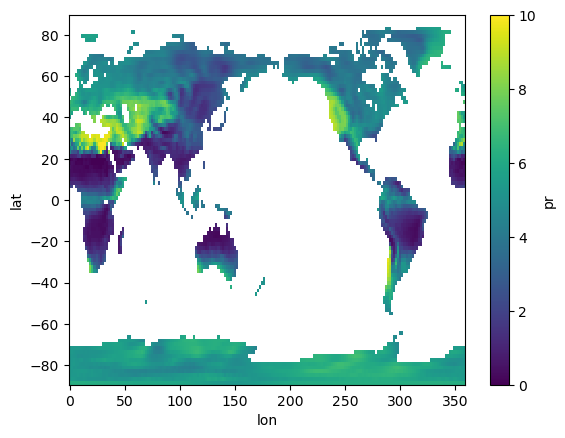

In [476]:
Pw_cm = Pw/10

Pw_cm.plot(vmin=0, vmax=10)

In [477]:
#now get seasonal means for both precip and temp 
tas_winter_mean = tas_winter.mean(dim='time')
tas_summer_mean = tas_summer.mean(dim='time')
pr_winter_mean = pr_winter.mean(dim='time')
pr_summer_mean = pr_summer.mean(dim='time')

In [478]:
#DO NOT use these variables to count months, use them for broad criteria that doesn't depend on monthly data 
#defining winter precip 
P_winter = xr.where((tas_winter_mean > tas_summer_mean), pr_summer_mean, pr_winter_mean)
#defining summer precip
P_summer = xr.where((tas_winter_mean > tas_summer_mean), pr_winter_mean, pr_summer_mean)

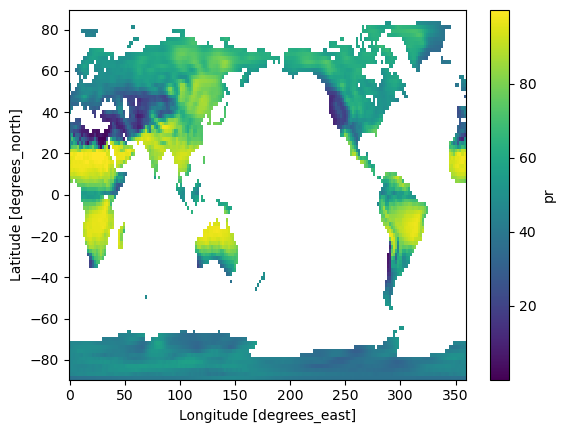

In [479]:
months = np.arange(1, 13) #1 = Jan, 12 = Dec
high_sun_NH = np.logical_and(months>=4, months<=9) #april-september
high_sun_SH = np.logical_or(months>=10, months<=3) #october-march

pr_NH = pr_monthly.where(lat >= 0)
pr_SH = pr_monthly.where(lat < 0)
#getting high sun months
pr_NH_var = pr_NH
pr_NH_high_sun = pr_NH_var.sel(month=high_sun_NH)
pr_SH_var = pr_SH
pr_SH_high_sun = pr_SH_var.sel(month=high_sun_SH)
#getting percentages of high sun month precip compared to total annual precip
pr_NH_high_sun_summed = pr_NH_high_sun.sum(dim=('month'))
pr_SH_high_sun_summed = pr_SH_high_sun.sum(dim=('month'))
P_NH = (pr_NH_high_sun_summed / P_ann) * 100
P_SH = (pr_SH_high_sun_summed / P_ann) * 100
#combining hemispheres
P = P_SH + P_NH
P.plot()

new pthresh
==

In [480]:
MAT_C = MAT - 273.15 #converting MAT to celsius because the aridity threshold formula uses celsius 
#MAT_C.plot()

aridity_thresh_1 = ((MAT_C - 10) * 10) + (3 * P)

Tcold = temperature_dataset_masked['tas'].sel(time=slice(start, end)).groupby("time.month").mean().min(dim='month')
Thot = temperature_dataset_masked['tas'].sel(time=slice(start, end)).groupby("time.month").mean().max(dim='month')

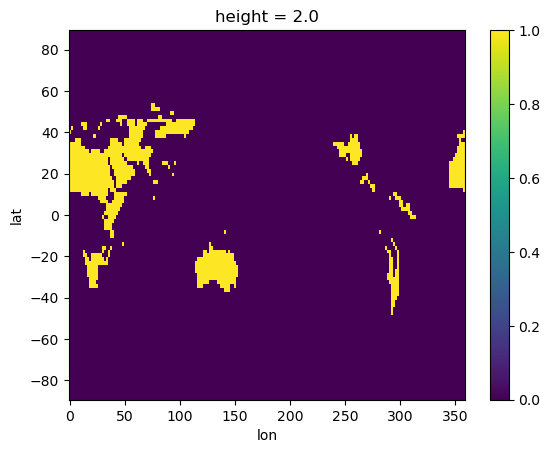

In [481]:
B = xr.where((MAP < (2*aridity_thresh_1)), True, False)
B.plot()

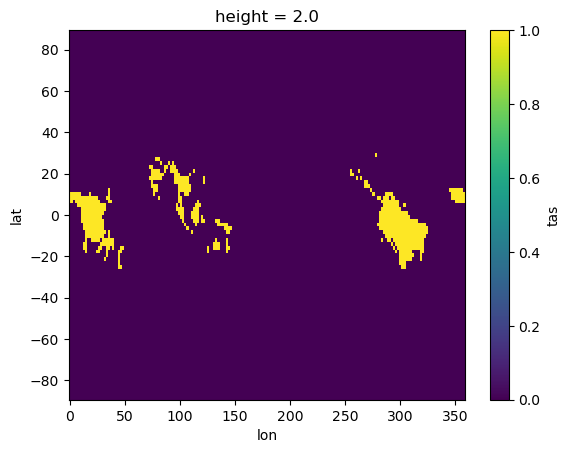

In [482]:
A_1 = xr.where((Tcold>(273.15+18)), True, False)
A = xr.where(np.logical_and(A_1, ~B), True, False)
A.plot()

In [483]:
Pdry =  pr_converted.sel(time=slice(start, end)).groupby("time.month").mean().min(dim='month')

Pmonth_1 = pr_converted.sel(time=slice(start, end))
Pmonth_2 = Pmonth_1.groupby('time.month')
Pmonth = Pmonth_2.mean(dim='time')

Ar_crit = xr.where(Pmonth>60, True, False)
Pmonth_crit = Ar_crit.sum(dim='month')

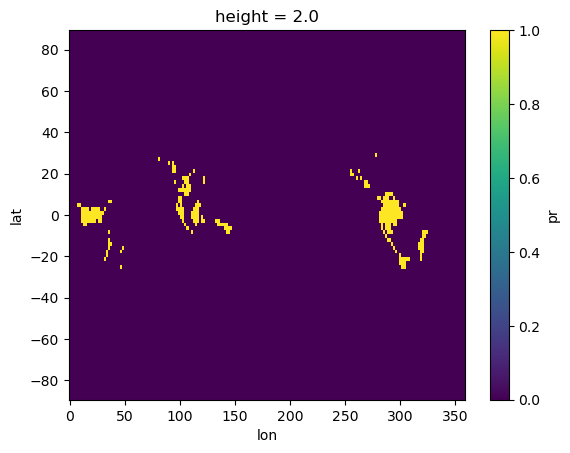

In [484]:
rainforest_crit = Pmonth_crit > 10
Ar = xr.where(np.logical_and(rainforest_crit, A), True, False)
Ar.plot()

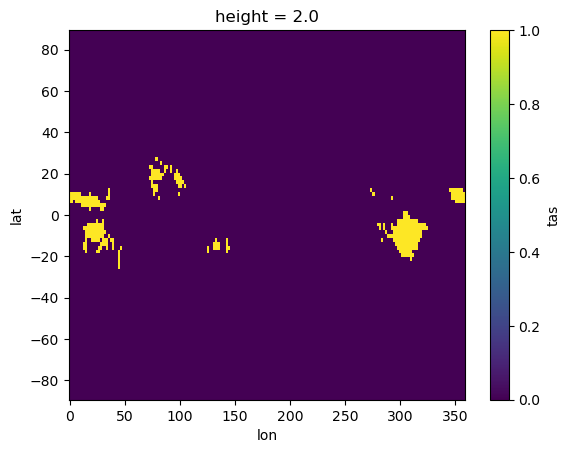

In [485]:
Aw_crit = (pr_winter < 60)
Pwint_crit = Aw_crit.sum(dim='time')
Aw_month_crit = Pwint_crit > 2

#creating Aw map
Aw = xr.where(np.logical_and(A, ~Ar), True, False)
Aw.plot()

In [486]:
#sanity check
Ar_area = (Ar*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
Aw_area = (Aw*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100
A_area = (A*area_dataset['areacella']).sum()/area_dataset['areacella'].sum()*100

(Ar_area + Aw_area) - A_area

<xarray.DataArray ()> Size: 4B
array(0., dtype=float32)
Coordinates:
    height   float64 8B 2.0

new working xA criteria work 
==

A where any one month out of the year is on average greater than 40 C

In [487]:
tas_40_1 = tas.sel(time=slice(start, end))
tas_40_2 = tas_40_1.groupby('time.month')
tas_monthly_2 = tas_40_2.mean(dim='time')

crit_novel = xr.where(tas_monthly_2 > (40+273.15), True, False)
tas_crit_novel = crit_novel.sum(dim='month')

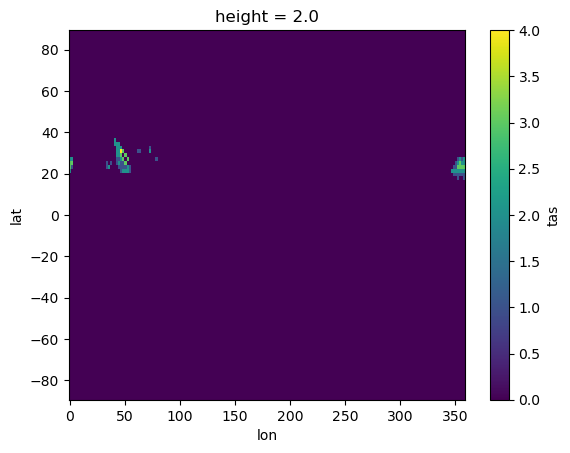

In [488]:
tas_crit_novel.plot()
#this is counting how many months are above 40 C on average
#so basically, if criteria is at least one month is greater than 40 C, then tas_crit_novel >= 1

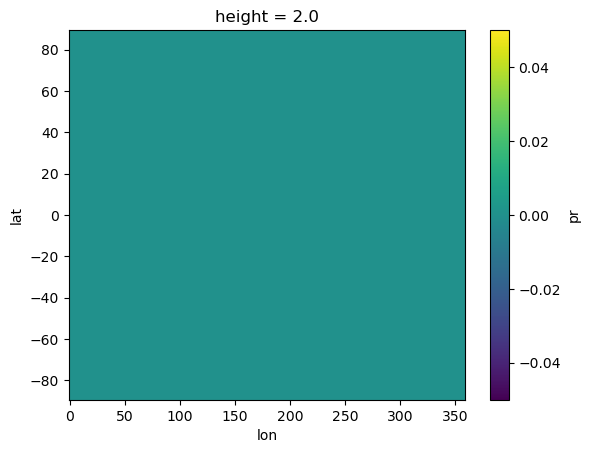

In [489]:
xAr = xr.where(np.logical_and(Ar, tas_crit_novel >= 1), True, False)
xAr.plot()

In [490]:
#empty mask to fill later - match dims w/ tas_monthly_2
high_sun_mask = xr.full_like(tas_monthly_2, False, dtype=bool)

#get coords to match the dims so you can broadcast tas_monthly_2 and high_sun 
latitudes = tas_monthly_2['lat']
longitudes = tas_monthly_2['lon']

#convert high_sun to data arrays
high_sun_NH_da = xr.DataArray(high_sun_NH, dims=['month']).broadcast_like(tas_monthly_2.isel(lat=0))
high_sun_SH_da = xr.DataArray(high_sun_SH, dims=['month']).broadcast_like(tas_monthly_2.isel(lat=0))

for i, lat in enumerate(latitudes.values):
    if lat > 0:
        high_sun_mask[:, i, :] = high_sun_NH_da
    else:
        high_sun_mask[:, i, :] = high_sun_SH_da
        
#new crit for xAw
crit_temp = tas_monthly_2 > (40 + 273.15)
crit_novel_2 = crit_temp & high_sun_mask
tas_crit_novel_2 = crit_novel.sum(dim='month')

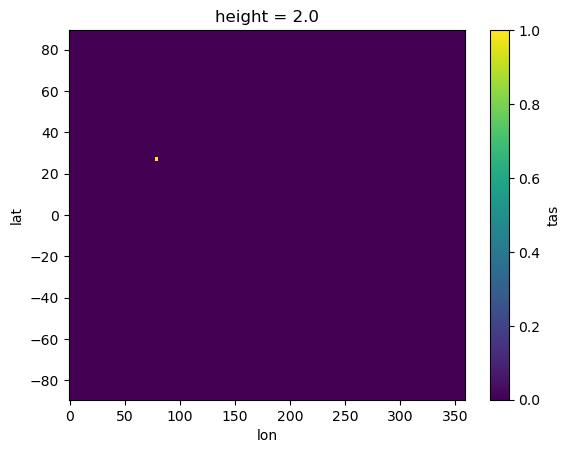

In [491]:
xAw = xr.where(np.logical_and(Aw, tas_crit_novel_2 >= 1), True, False)
xAw.plot()

In [492]:
dict = {
    "xAr": {"dataset": xAr, "variable": "xAr"},
    "xAw": {"dataset": xAw, "variable": "xAw"}
}

In [493]:
zone_ids = {"xAr": 1, "xAw":2}
zone_colors = {"xAr": "blue", "xAw":"deepskyblue"}

In [494]:
lat_array = np.array(tas["lat"])
lon_array = np.array(tas["lon"])
combined_grid = np.full_like(lat_array[:, None] * lon_array[None, :], np.nan, dtype=float)

for zone, info in dict.items():
    ds_2 = info["dataset"]
    variable = info["variable"]
    data = ds_2
    mask = ~np.isnan(data) & (data > 0)  
    combined_grid = np.where(mask & np.isnan(combined_grid), zone_ids[zone], combined_grid)

cmap = mcolors.ListedColormap([zone_colors[zone] for zone in zone_ids.keys()])
bounds = [0.5 + i for i in range(len(zone_ids) + 1)]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

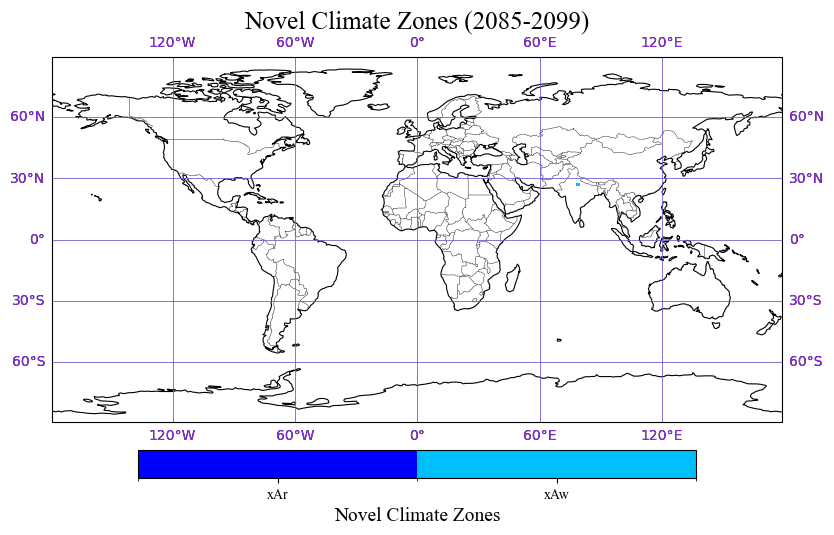

In [495]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_title("Novel Climate Zones (2085-2099)", fontsize=18, fontname='Times New Roman')
lon, lat = np.meshgrid(tas["lon"].values, tas["lat"].values)
pcolormesh = ax.pcolormesh(lon, lat, combined_grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='auto')
#adding a legend/key :)
handles = [
    plt.Line2D([0], [0], marker="o", color=color, linestyle="", label=zone)
    for zone, color in zone_colors.items()
]

cbar = fig.colorbar(pcolormesh, ax=ax, orientation="horizontal", pad=0.06, shrink=0.6, ticks=list(zone_ids.values()))
cbar.set_label("Novel Climate Zones", fontsize=14, fontname='Times New Roman')
cbar.set_ticks(list(zone_ids.values()))
cbar.set_ticklabels(list(zone_ids.keys()), fontname='Times New Roman')
ax.coastlines(linewidth=0.8)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='slateblue', linewidth = 0.4)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, 
                  color='slateblue', linewidth=0.4)
gl.xlabel_style = {"size": 10, "color": "blueviolet"}  #lon labels
gl.ylabel_style = {"size": 10, "color": "blueviolet"}  #lat labels
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.3)

In [496]:
ds = xr.Dataset()
ds['lat'] = A.lat
ds['lon'] = A.lon



ds['xAr'] = xAr
ds['xAr'].attrs= {'long_name' : 'novel tropical rainforest'}
ds['xAw'] = xAw
ds['xAw'].attrs= {'long_name' : 'novel tropical savanna'}

In [497]:
ds.to_netcdf(path='/Users/jaybr/OneDrive/Desktop/RESEARCH/MPI-ESM1-2-LR_novel_dataset_G6sulfur', mode='w')